<h1>Project 4: SafeComm Digital Security Solutions</h1>
<p>Team Captain: E00020</p>
<p>Member 2: E00491</p>
<p>Member 3: E00045</p>
</br></br>
<h2>Table of Contents</h2>
<ol>
  <li><a href="#section1">Importing Libaries</a></li>
  <li><a href="#section2">Importing and Inspecting Data</a></li>
  <li><a href="#section3">EDA</a></li>
  <li><a href="#section4">Data Preprocessing</a></li>
  <li><a href="#section5">Models</a></li>
  <li><a href="#section6">Testing</a></li>
</ol>
</br></br>

<h3 id="section1">Setup</h3>

In [2]:
# importing all necessary libaries => delete used!
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
import re
import string
import unicodedata
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from textblob import TextBlob
from textblob import Word
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')


<h3 id="section2">Importing and Inspecting Data</h3>

In [90]:
# importing the csv into a pandas data frame
df = pd.read_csv("./sms.csv")
print("Shape: ", df.shape)
print("Head: ", df.head())

# checking the distribution of each variable type
variable_types = df.dtypes
print("Variable Types")
print(variable_types)

# checking for missing values in the dataset
missing_values_count = df.isnull().sum()
print("Missing Values:")
print(missing_values_count)

# checking if there are any duplicates in the dataset
duplicates = df.duplicated()
print("Duplicates:")
print(duplicates.count())

# checking if the data is balanced in regard to fraudulent and non-fraudulent
print(df["Fraudolent"].value_counts())


# checking the distribution of each column => necessary?
for col in df:
    print(col, ":", len(df[col].unique()))




Shape:  (5572, 4)
Head:     Fraudolent                                           SMS_test       ID  \
0           0  Squeeeeeze!! This is christmas hug.. If u lik ...  1EWYRBL   
1           0  And also I've sorta blown him off a couple tim...  ZY4PDK7   
2           0  Mmm thats better now i got a roast down me! i...  KLUX2C6   
3           0      Mm have some kanji dont eat anything heavy ok  955HXJ0   
4           0  So there's a ring that comes with the guys cos...  00Q6EUC   

  Date and Time  
0    2017-12-02  
1    2018-03-23  
2    2016-10-29  
3    2018-04-12  
4    2016-08-01  
Variable Types
Fraudolent        int64
SMS_test         object
ID               object
Date and Time    object
dtype: object
Missing Values:
Fraudolent       0
SMS_test         0
ID               0
Date and Time    0
dtype: int64
Duplicates:
5572
0    4825
1     747
Name: Fraudolent, dtype: int64
Fraudolent : 2
SMS_test : 5157
ID : 5572
Date and Time : 946


<p>notice here especially: data is not balanced and there are overlapping times and message contents => could mybe point to spam?</p>

<h3 id="section3">Exploratory Data Analysis<h3>


Summary Statistics:
        Fraudolent
count  5572.000000
mean      0.134063
std       0.340751
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


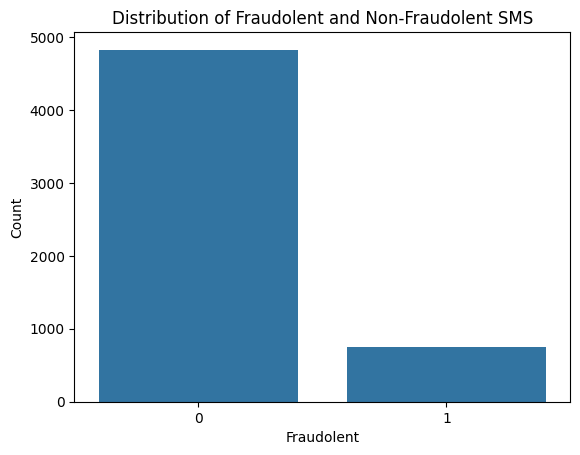

In [91]:
print("Summary Statistics:")
print(df.describe())

sns.countplot(data=df, x="Fraudolent")
plt.title('Distribution of Fraudolent and Non-Fraudolent SMS')
plt.xlabel('Fraudolent')
plt.ylabel('Count')
plt.show()


<h3 id="section4">Data Preprocessing</h3>

In [109]:
# splitting the dataframe into training set and test set
# X = df["SMS test"]
# y = df["Fraudolent"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=
#                                                     0.25, random_state=1)
TRAIN_TEST_SPLIT = 3714

#train dataset
train_text=df.SMS_test[:TRAIN_TEST_SPLIT]
train_sentiments=df.Fraudolent[:TRAIN_TEST_SPLIT]

#test dataset
test_text=df.SMS_test[TRAIN_TEST_SPLIT:]
test_sentiments=df.Fraudolent[TRAIN_TEST_SPLIT:]

print(train_text.shape, train_sentiments.shape)
print(test_text.shape, test_sentiments.shape)


(3714,) (3714,)
(1858,) (1858,)


In [ ]:
# handle missing values


In [118]:
# text normalization
nltk.download('stopwords')

# tokenization of text
tokenizer=ToktokTokenizer()

# setting english stopwords
stopword_list=nltk.corpus.stopwords.words('english')

#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#apply function on review column
df['SMS_test']=df['SMS_test'].apply(denoise_text)

#Define function for removing special characters
def remove_special_characters(text):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#apply function on review column
df['SMS_test']=df['SMS_test'].apply(remove_special_characters)

#stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#apply function on review column
df['SMS_test']=df['SMS_test'].apply(simple_stemmer)

#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

#apply function on text column
df['SMS_test']=df['SMS_test'].apply(remove_stopwords)

#normalized train reviews
norm_train_text=df.SMS_test[:TRAIN_TEST_SPLIT]
norm_train_text[0]

#Normalized test reviews
norm_test_text=df.SMS_test[TRAIN_TEST_SPLIT:]
norm_test_text[4000]

#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=True,ngram_range=(1,3))


#transformed train reviews
cv_train_text=cv.fit_transform(norm_train_text)

#transformed test reviews
cv_test_text=cv.transform(norm_test_text)

print('BOW_cv_train:', cv_train_text.shape)
print('BOW_cv_test:', cv_test_text.shape)

#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3))

#transformed train reviews
tv_train_text=tv.fit_transform(norm_train_text)

#transformed test reviews
tv_test_text=tv.transform(norm_test_text)

print('Tfidf_train:', tv_train_text.shape)
print('Tfidf_test:', tv_test_text.shape)

print(df.head())

#labeling the sentiment data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(df['Fraudolent'])
print(sentiment_data.shape)

conf_matrices = {}


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arthurbirnstiel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{"it's", "you'd", "wasn't", 'only', 'than', 'most', 'all', 'am', 'between', 'to', 'shouldn', 'me', 'her', 'below', 'down', 'on', 'ma', "shouldn't", 'will', 'what', 'you', 'him', 'themselves', 'now', 'doesn', 'just', "weren't", 'both', 'at', 'why', 'yours', 'were', 'll', 're', 'shan', 'which', 's', 'once', 'can', 'have', 'be', 'our', 'no', 'your', "don't", 'during', 'isn', 'but', "mustn't", "hadn't", 'as', 'so', 'those', 'same', 'there', 'we', 'few', 'do', 'himself', 'when', 'its', "shan't", 'here', 'mustn', 'in', "couldn't", 'more', 'own', 'against', 'a', 'for', 'are', 'this', "needn't", 'by', 'haven', 'wouldn', 'o', "haven't", 'does', "hasn't", 'being', 'not', 'yourself', 'my', 'couldn', 'into', 'it', "didn't", 'doing', 'yourselves', 'they', "you'll", "should've", 'about', 'she', "doesn't", 'weren', 'aren', 'other', 'off', 'how', 'd', 'did', "you're", 'hers', 'whom', 'until', 'with', 'itself', 'hadn', 'should', 'had', 'if', 'theirs', 'because', "wouldn't", 'who', 'needn', "you've", 'u

<h3 id="section5">Models</h3>

lr_bow_score : 0.9494079655543596
lr_tfidf_score : 0.926264800861141
              precision    recall  f1-score   support

    Positive       0.99      0.96      0.97      1606
    Negative       0.76      0.91      0.83       252

    accuracy                           0.95      1858
   macro avg       0.87      0.93      0.90      1858
weighted avg       0.96      0.95      0.95      1858

              precision    recall  f1-score   support

    Positive       0.92      1.00      0.96      1606
    Negative       0.98      0.47      0.63       252

    accuracy                           0.93      1858
   macro avg       0.95      0.73      0.80      1858
weighted avg       0.93      0.93      0.91      1858



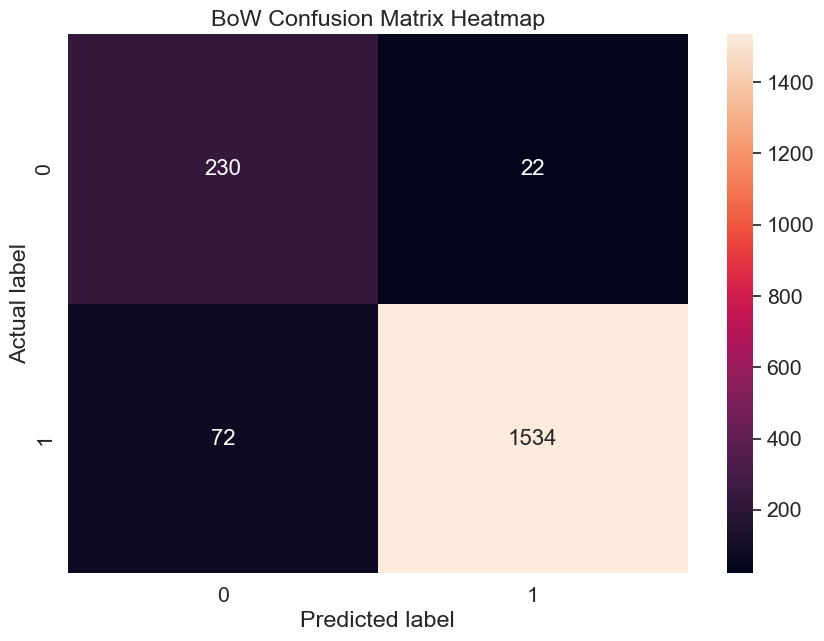

In [119]:
# model 1: log regression
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_text,train_sentiments)

#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_text,train_sentiments)

#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_text)

#Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_text)
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

#Classification report for bag of words
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

# confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
conf_matrices["lr_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


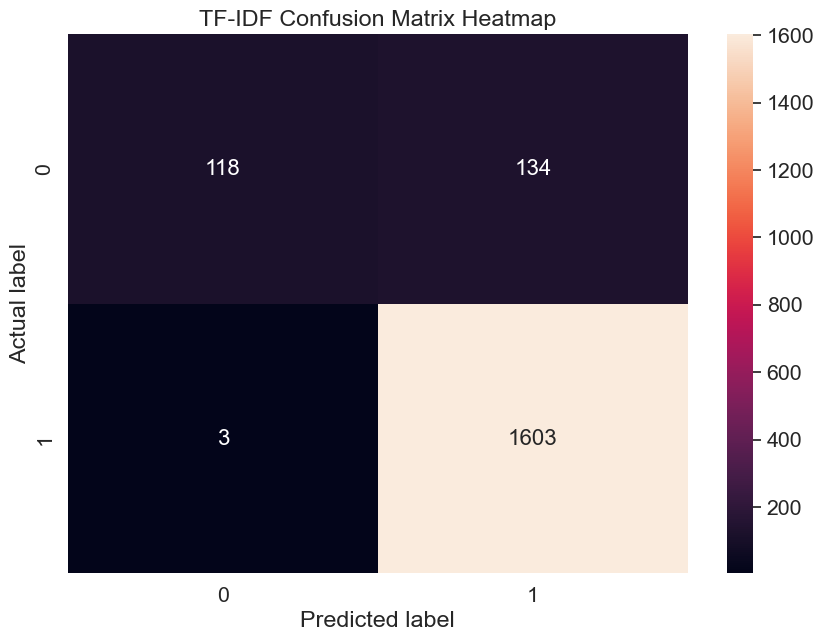

In [120]:
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
conf_matrices["lr_tfidf"] = cm_tfidf

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


svm_bow_score : 0.9477933261571583
svm_tfidf_score : 0.9768568353067815
              precision    recall  f1-score   support

    Positive       0.99      0.95      0.97      1606
    Negative       0.74      0.96      0.83       252

    accuracy                           0.95      1858
   macro avg       0.86      0.95      0.90      1858
weighted avg       0.96      0.95      0.95      1858

              precision    recall  f1-score   support

    Positive       0.98      0.99      0.99      1606
    Negative       0.95      0.88      0.91       252

    accuracy                           0.98      1858
   macro avg       0.96      0.93      0.95      1858
weighted avg       0.98      0.98      0.98      1858



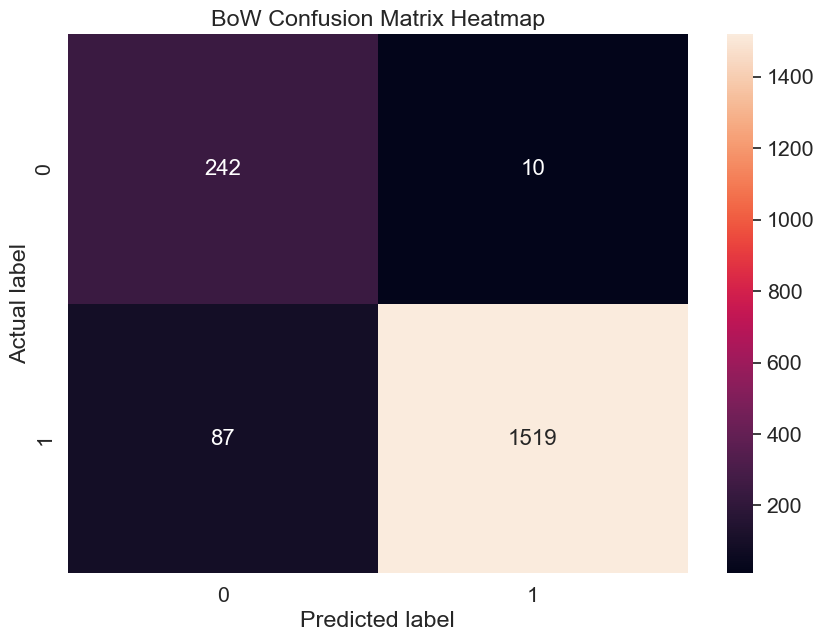

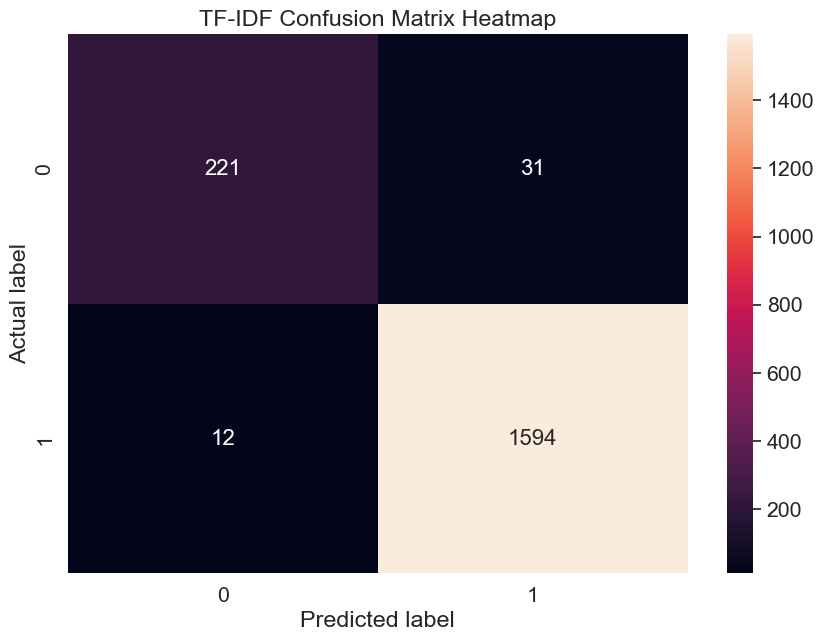

In [127]:
# model 2
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)

#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_text,train_sentiments)

#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_text,train_sentiments)

#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_text)

#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_text)

#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)

#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

#Classification report for bag of words
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)

#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
conf_matrices["svm_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
conf_matrices["svm_tfidf"] = cm_tfidf

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


mnb_bow_score : 0.9601722282023681
mnb_tfidf_score : 0.9311087190527448
              precision    recall  f1-score   support

    Positive       0.96      1.00      0.98      1606
    Negative       0.99      0.71      0.83       252

    accuracy                           0.96      1858
   macro avg       0.98      0.85      0.90      1858
weighted avg       0.96      0.96      0.96      1858

              precision    recall  f1-score   support

    Positive       0.93      1.00      0.96      1606
    Negative       1.00      0.49      0.66       252

    accuracy                           0.93      1858
   macro avg       0.96      0.75      0.81      1858
weighted avg       0.94      0.93      0.92      1858



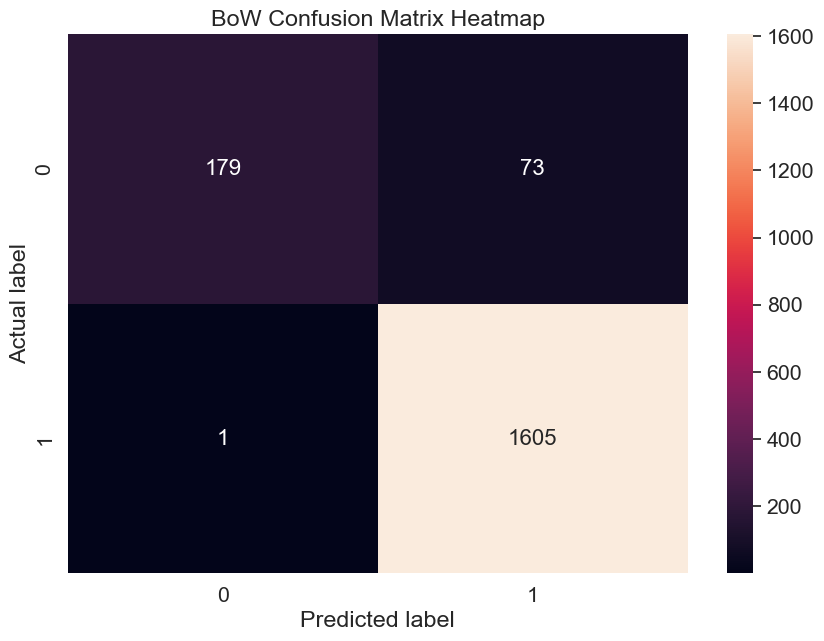

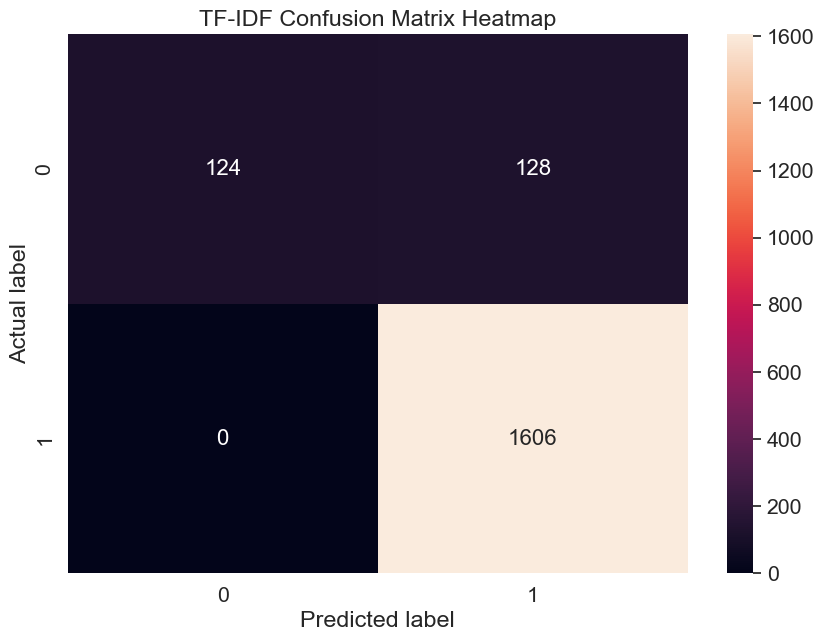

In [129]:
# model 3
#training the model
mnb=MultinomialNB()

#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_text,train_sentiments)

#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_text,train_sentiments)

#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_text)

#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_text)

#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

#Classification report for bag of words
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)

#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
conf_matrices["mnb_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
conf_matrices["mnb_tfidf"] = cm_tfidf

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


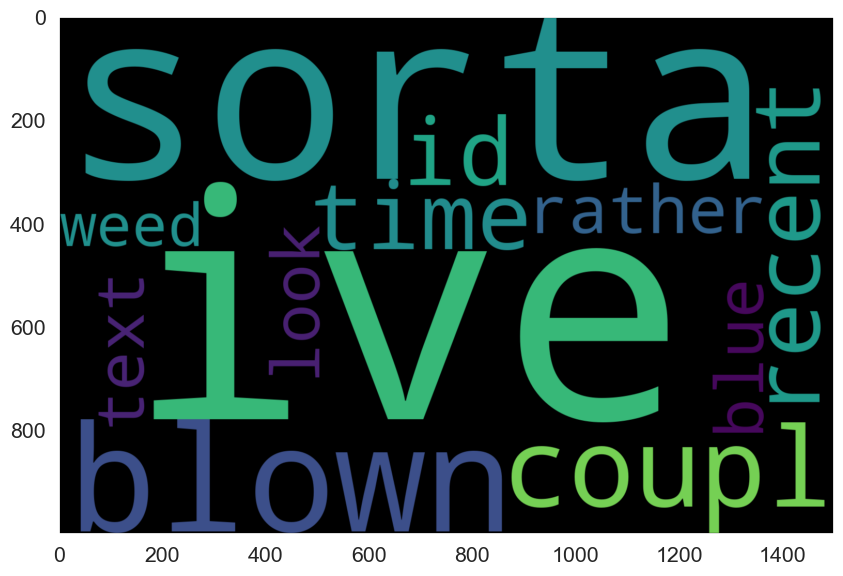

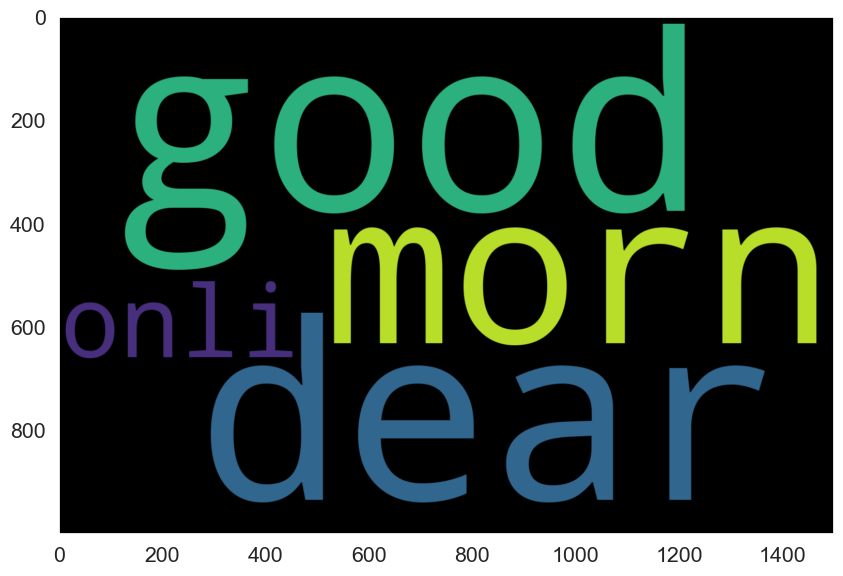

In [131]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_text[1]
WC=WordCloud(width=1500,height=1000,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.grid(False)
plt.show()

#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_text[8]
WC=WordCloud(width=1500,height=1000,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.grid(False)
plt.show()


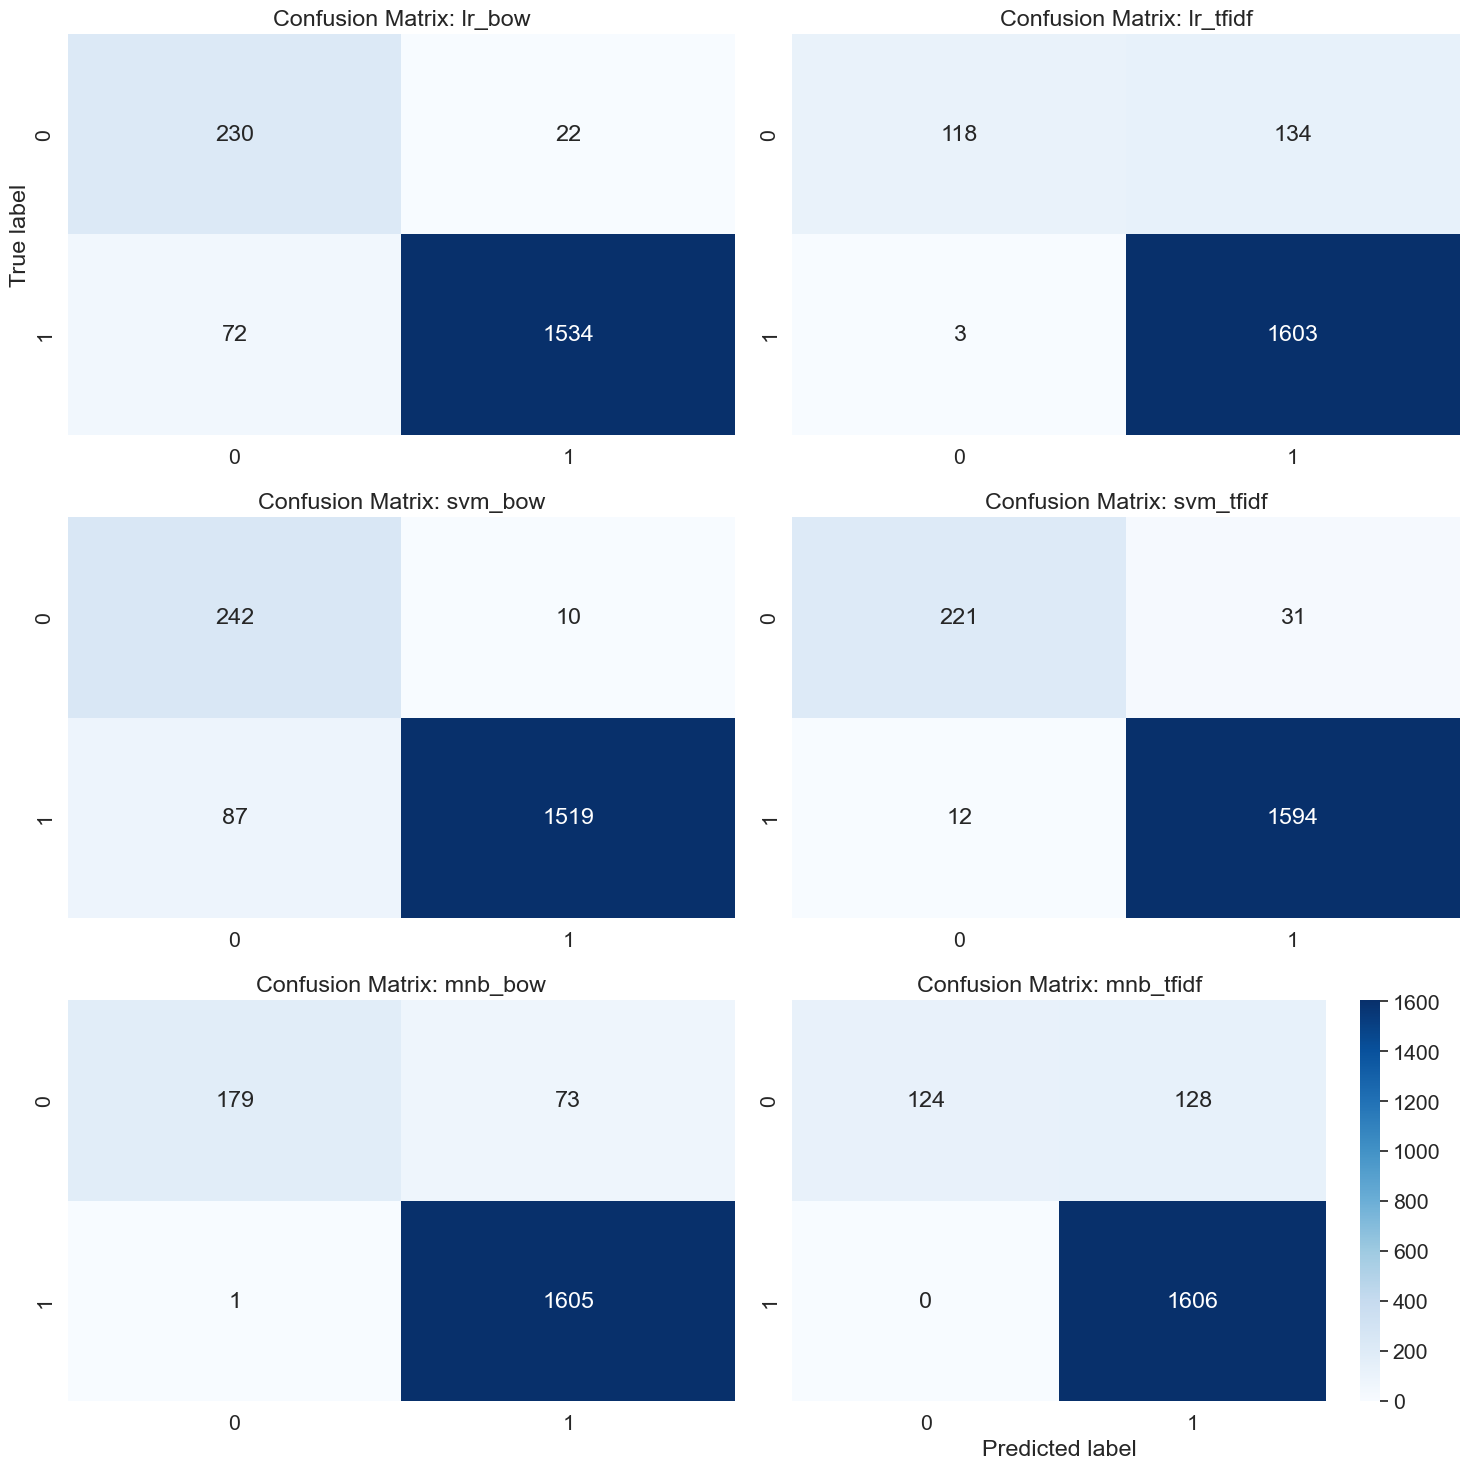

In [132]:
def plot_confusion_matrix(ax, conf_matrix, classifier_name, position):
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=(position == 'last'))
    ax.set_title(f'Confusion Matrix: {classifier_name}')
    if position in ['first', 'middle']:
        ax.set_xlabel('')  # Remove x-label
    else:
        ax.set_xlabel('Predicted label')
    if position in ['middle', 'last']:
        ax.set_ylabel('')  # Remove y-label
    else:
        ax.set_ylabel('True label')

# Determine the number of classifiers (and hence, the number of subplots required)
num_classifiers = len(conf_matrices)

# Create subplots
fig, axes = plt.subplots(num_classifiers // 2, 2, figsize=(15, 5 * (num_classifiers // 2)))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
positions = ['first'] + ['middle'] * (num_classifiers - 2) + ['last']
for ax, (classifier_name, conf_matrix), position in zip(axes, conf_matrices.items(), positions):
    plot_confusion_matrix(ax, conf_matrix, classifier_name, position)

plt.tight_layout()
plt.show()


<h3 id="section6">Testing</h3>

In [ ]:
# alt run tests in seperate file?
